##### importing libraries

In [1]:
import os
import cv2
from random import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

##### extracting data from local dir

In [2]:
data = {
    'imgs' : [],
    'labels' : []
}

datapath = r"C:\Users\US593\OneDrive\Desktop\conveyor_belt_pizza_counter\classifier\data"
count = 0 

for classes in os.listdir(datapath):
    classes_path = os.path.join(datapath,classes)
    class_name = classes
    for filename in os.listdir(classes_path):
        if filename is not None: 
            data['labels'].append(class_name)
            filepath = os.path.join(classes_path,filename)
            img = cv2.imread(filepath)
            resized_img = cv2.resize(img,(7,7))
            img = cv2.cvtColor(resized_img,cv2.COLOR_BGR2RGB)
            data['imgs'].append(img)
            count += 1
            if count%100 == 0 : 
                print(f"processed {count}")

processed 100
processed 200
processed 300
processed 400
processed 500
processed 600
processed 700
processed 800
processed 900


##### shuffling data for better visualization

In [3]:
combined = list(zip(data['imgs'], data['labels']))
shuffle(combined)
data['shuffled_imgs'],data['shuffled_labels'] = zip(*combined)

##### data visualization

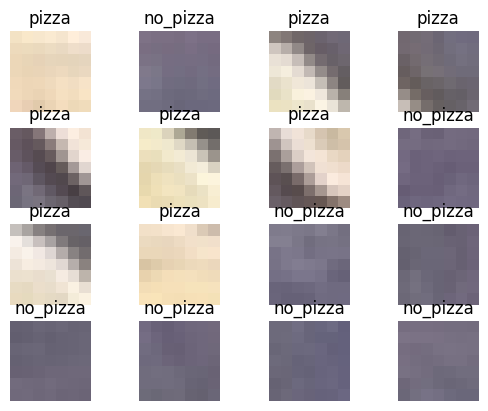

In [4]:
i = 0
for label , img in zip(data['shuffled_labels'][:16],data['shuffled_imgs'][:16]):
    ax = plt.subplot(4,4,i+1) # create subplot with in grid with (rows,columns,index)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
    i += 1
    if i == 16:
        break

##### label_encoding

In [5]:
data.keys()

dict_keys(['imgs', 'labels', 'shuffled_imgs', 'shuffled_labels'])

In [6]:
labels = np.array(data['shuffled_labels'])

In [7]:
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

In [8]:
encoded_labels.shape

(983,)

In [9]:
encoded_labels[:5]

array([1, 0, 1, 1, 1], dtype=int64)

1 ==> pizza

0 ==> no_pizza

##### flattening-out images

In [10]:
images = np.array(data['shuffled_imgs'])

In [11]:
images.shape

(983, 7, 7, 3)

In [13]:
flattened_imgs = np.reshape(images, (983,147))

In [14]:
flattened_imgs.shape

(983, 147)

##### normalization

In [15]:
flattened_imgs[0][:10]

array([243, 226, 196, 249, 232, 202, 247, 231, 205, 250], dtype=uint8)

In [16]:
scaler = MinMaxScaler()

In [17]:
scaled_imgs = scaler.fit_transform(flattened_imgs)

In [18]:
scaled_imgs[0][:10]

array([0.92814371, 0.91975309, 0.77083333, 0.96449704, 0.95151515,
       0.84516129, 0.95092025, 0.93630573, 0.87313433, 0.98802395])

In [19]:
pickle.dump(scaler, open(f'min_max_scaler.p', 'wb'))

##### trian_test_split

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
x_train,x_test,y_train,y_test = train_test_split(scaled_imgs, encoded_labels, test_size = 0.2, stratify = encoded_labels, shuffle = True, random_state = 33)

In [22]:
x_train.shape

(786, 147)

In [23]:
y_train.shape

(786,)

In [24]:
x_test.shape

(197, 147)

In [25]:
y_test.shape

(197,)

##### training multiple models using GridSearchCV

In [26]:
import pickle
import pandas as pd
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC

def gridsearchcv(X, y):
    algos = {
        'naive_bayes': {
            'model': GaussianNB(),
            'params': {
               'priors' : [None]
            }
        },
        'random_forest': {
            'model': RandomForestClassifier(),
            'params': {
                'criterion' : ['gini']
            }
        },
        'logistic_regression': {
            'model': LogisticRegression(max_iter=10000),
            'params': {}  # No hyperparameters to tune
        },
        'xgboost': {
            'model': XGBClassifier(),
            'params': {}  # No hyperparameters to tune
        },
        'svc': {
            'model': SVC(),
            'params': {
                'kernel': ['linear', 'poly', 'rbf'],
                'C': [0.1, 1],
                'gamma': ['scale']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gscv = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gscv.fit(X, y)
        scores.append({
            'model': algo_name,
            'best_score': gscv.best_score_,
            'best_params': gscv.best_params_
        })
        best_estimator = gscv.best_estimator_
        pickle.dump(best_estimator, open(f'{algo_name}_model.p', 'wb'))
        
    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

In [27]:
stats = gridsearchcv(x_train,y_train)

##### saving & showing training stats

In [28]:
stats.to_csv('stats.csv')

In [29]:
stats

,model,best_score,best_params
0,naive_bayes,0.962025,{'priors': None}
1,random_forest,0.986076,{'criterion': 'gini'}
2,logistic_regression,0.974684,{}
3,xgboost,0.984810,{}
4,svc,0.978481,"{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}"


##### Naive Bayes Model Evaluation

In [30]:
with open('naive_bayes_model.p', 'rb') as file:
    model1 = pickle.load(file)

In [31]:
model1.score(x_train,y_train)

0.9516539440203562

In [32]:
model1.score(x_test,y_test)

0.949238578680203

Text(58.222222222222214, 0.5, 'Truth')

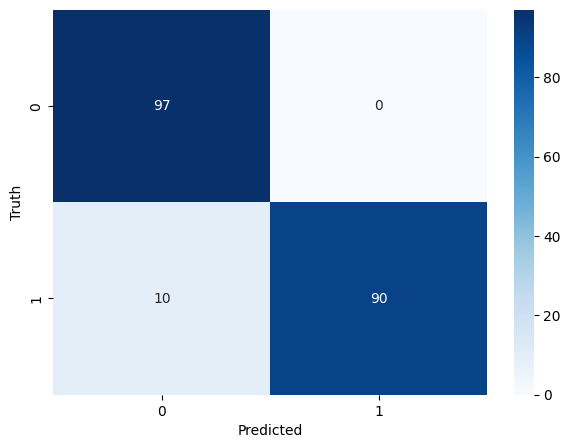

In [33]:
cm = confusion_matrix(y_test, model1.predict(x_test))
plt.figure(figsize = (7,5))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Truth')

##### Random Forest Model Evaluation

In [34]:
with open('random_forest_model.p', 'rb') as file:
    model2 = pickle.load(file)

In [35]:
model2.score(x_train,y_train)

0.9949109414758269

In [36]:
model2.score(x_test,y_test)

1.0

Text(58.222222222222214, 0.5, 'Truth')

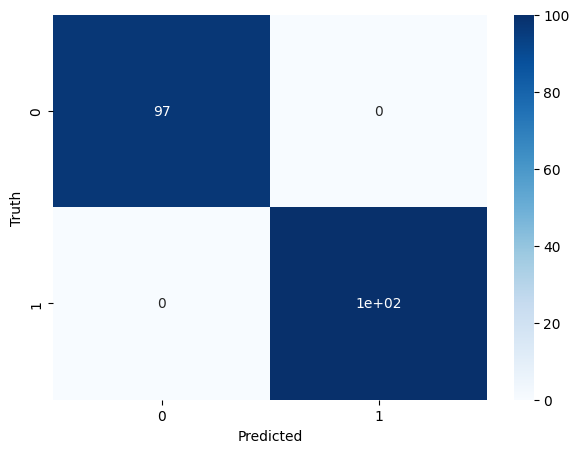

In [37]:
cm = confusion_matrix(y_test, model2.predict(x_test))
plt.figure(figsize = (7,5))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Truth')

##### Logisitic Regression Model Evaluation

In [38]:
with open('logistic_regression_model.p', 'rb') as file:
    model3 = pickle.load(file)

In [39]:
model3.score(x_train,y_train)

0.9758269720101781

In [40]:
model3.score(x_test,y_test)

0.9746192893401016

Text(58.222222222222214, 0.5, 'Truth')

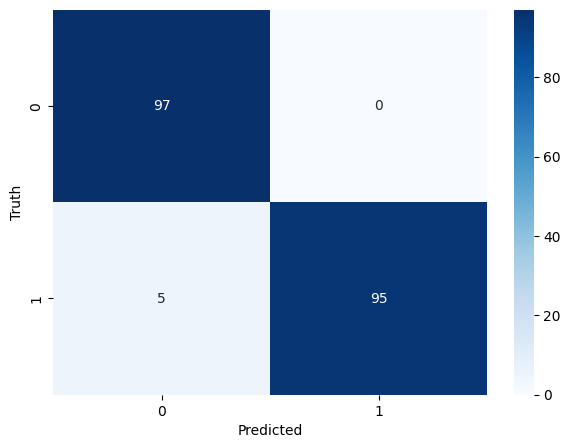

In [41]:
cm = confusion_matrix(y_test, model3.predict(x_test))
plt.figure(figsize = (7,5))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Truth')

##### XGBoost Model Evaluation

In [42]:
with open('xgboost_model.p', 'rb') as file:
    model4 = pickle.load(file)

In [43]:
model4.score(x_train,y_train)

0.9949109414758269

In [44]:
model4.score(x_test,y_test)

0.9847715736040609

Text(58.222222222222214, 0.5, 'Truth')

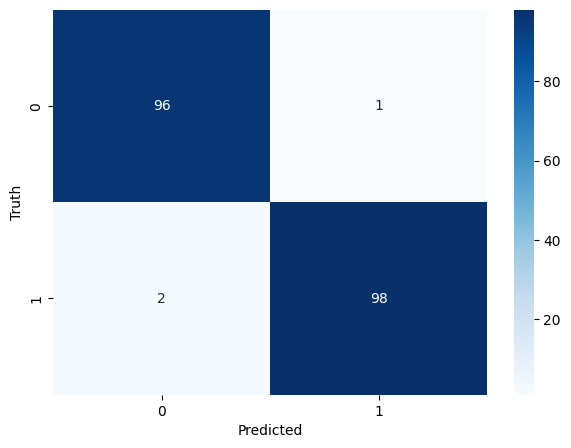

In [45]:
cm = confusion_matrix(y_test, model4.predict(x_test))
plt.figure(figsize = (7,5))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Truth')

##### SVC Model Evaluation

In [46]:
with open('svc_model.p', 'rb') as file:
    model5 = pickle.load(file)

In [47]:
model5.score(x_train,y_train)

0.9834605597964376

In [48]:
model5.score(x_test,y_test)

0.9847715736040609

Text(58.222222222222214, 0.5, 'Truth')

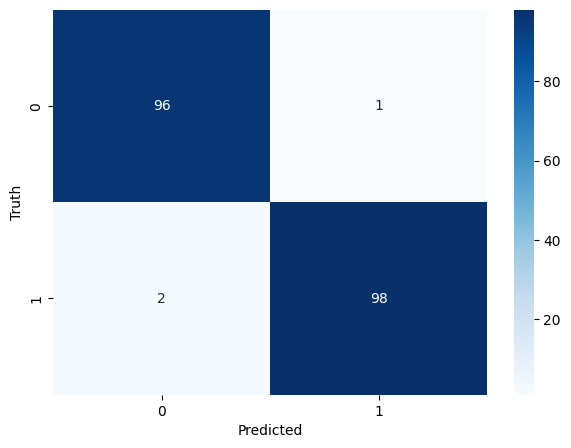

In [49]:
cm = confusion_matrix(y_test, model5.predict(x_test))
plt.figure(figsize = (7,5))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Truth')